# Exploring & Processing Data

In this jupyter notebook we will explore the datasets used for our project. We will primarily focus on 

In [69]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import xyzservices.providers as xyz
from census import Census

import os

from shapely.geometry import Point, Polygon

# Loading environment variables
from dotenv import load_dotenv
load_dotenv()
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

## 311 Cases in 2023

Below is the raw table of all 311 service requests opened in 2023.

In [70]:
serv_req_df = pd.read_csv("data/raw/311_Cases_2023.csv")

Let's do a quick analysis of what this dataset consists of.

In [71]:
serv_req_df.sample(5)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Police District,Latitude,Longitude,Point,point_geom,Source,Media URL,BOS_2012,data_as_of,data_loaded_at
209050,16834758,05/25/2023 01:54:00 PM,05/25/2023 06:25:06 PM,05/25/2023 06:25:06 PM,Closed,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,All colors - Various - Unknown,...,SOUTHERN,37.771327,-122.392729,"(37.7713267, -122.3927289)",POINT (-122.3927289 37.7713267),Web,NaN,6.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
284376,16646876,04/08/2023 03:03:51 PM,04/09/2023 05:36:50 AM,04/09/2023 05:36:50 AM,Closed,Case Resolved - Pickup completed.,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,...,MISSION,37.760358,-122.419347,"(37.76035812, -122.41934659)",POINT (-122.419346587 37.760358124),Mobile/Open311,NaN,9.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
219566,16487063,02/28/2023 05:21:00 PM,03/01/2023 05:48:52 PM,03/01/2023 05:48:52 PM,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Boxed or Bagged Items,...,NORTHERN,37.774907,-122.437901,"(37.77490721, -122.43790054)",POINT (-122.437900538 37.774907208),Mobile/Open311,https://mobile311.sfgov.org/media/san_francisc...,5.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
778356,17483029,10/29/2023 02:17:00 PM,11/06/2023 05:00:10 PM,11/06/2023 05:00:10 PM,Closed,Case Transferred - Per process - cases are clo...,311 Service Request Queue - Hold,311 External Request,Graffiti,Graffiti,...,SOUTHERN,37.771886,-122.423397,"(37.77188553, -122.42339688)",POINT (-122.423396876 37.771885527),Phone,NaN,NaN,2024/04/10 10:23:00 AM,2024/09/11 05:09:50 PM
231395,16287830,01/11/2023 03:23:00 PM,03/06/2023 10:15:03 AM,03/06/2023 10:15:03 AM,Closed,Case Resolved - Maximo Service Request has bee...,PUC Sewer Ops,Sewer Issues,Sewage_back_up,Outofsewervent4inch,...,TARAVAL,0.000000,0.000000,"(0.0, 0.0)",POINT (0 0),Phone,NaN,7.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM


In [72]:
print(serv_req_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840206 entries, 0 to 840205
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CaseID                 840206 non-null  int64  
 1   Opened                 840206 non-null  object 
 2   Closed                 808740 non-null  object 
 3   Updated                840206 non-null  object 
 4   Status                 840206 non-null  object 
 5   Status Notes           835836 non-null  object 
 6   Responsible Agency     840206 non-null  object 
 7   Category               840206 non-null  object 
 8   Request Type           840206 non-null  object 
 9   Request Details        831141 non-null  object 
 10  Address                840206 non-null  object 
 11  Street                 830788 non-null  object 
 12  Supervisor District    830788 non-null  float64
 13  Neighborhood           830704 non-null  object 
 14  Analysis Neighborhood  732571 non-nu

## Cleaning the Service Requests DataFrame

### Initial Cleanup

In [73]:
# Selecting useful columns
useful_cols = [
    'CaseID', 'Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
    'Responsible Agency', 'Category', 'Request Type', 'Request Details',
    'Neighborhood', 'Analysis Neighborhood', 'Police District',
    'Latitude', 'Longitude', 'Source'
]

serv_req_df = serv_req_df[useful_cols].copy()

# Removing duplicates and filtering by SF bounding box
serv_req_df.drop_duplicates(subset='CaseID', inplace=True)
serv_req_df = serv_req_df[
    serv_req_df['Latitude'].between(37.6, 37.9) &
    serv_req_df['Longitude'].between(-123.2, -122.3)
]

# Simplifying column names
serv_req_df.columns = (
    serv_req_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

print("DataFrame snippet so far:\n")
display(serv_req_df.sample(3))

DataFrame snippet so far:



,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,neighborhood,analysis_neighborhood,police_district,latitude,longitude,source
67370,16270617,01/07/2023 08:56:00 PM,01/07/2023 09:05:32 PM,01/07/2023 09:05:32 PM,Closed,Case Resolved - Resolved by Arborist at 9:25PM,DPW Ops Queue,Tree Maintenance,Trees - Damaged_Tree,Fallen_tree,Japantown,Japantown,NORTHERN,37.785562,-122.433097,Mobile/Open311
123639,16482780,02/27/2023 07:02:00 PM,03/12/2023 09:39:33 AM,03/12/2023 09:39:33 AM,Closed,Case Resolved - SES Graffiti Crew - Remove Sig...,DPW Ops Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed Improperly,Russian Hill,Russian Hill,CENTRAL,37.800992,-122.414362,Mobile/Open311
614645,17604233,11/29/2023 11:09:00 AM,12/01/2023 11:10:00 AM,12/01/2023 11:10:00 AM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Crocker Amazon,Excelsior,INGLESIDE,37.711015,-122.446262,Mobile/Open311


### Categorizing Categoricals

We're just marking a column if they're a categorical or not.

In [74]:
cat_cols = [
    'status',
    'status_notes',
    'responsible_agency',
    'category',
    'request_type',
    'request_details',
    'neighborhood',
    'analysis_neighborhood',
    'police_district',
    'source'
]

for col in cat_cols:
    if col in serv_req_df.columns:
        serv_req_df[col] = (
            serv_req_df[col]
            .astype('string')                      # efficient string dtype
            .str.strip()                           # remove leading/trailing spaces
            .str.replace(r'\s+', ' ', regex=True)  # collapse multiple spaces
            .str.replace('_', ' ', regex=False)    # underscores → spaces
            .str.title()                           # nice display casing
        )

### Temporal Cleanup

In [75]:
# Properly format date columns
date_cols = ['opened', 'closed', 'updated']
for col in date_cols:
    serv_req_df[col] = pd.to_datetime(
        serv_req_df[col],
        format='%m/%d/%Y %I:%M:%S %p',
        errors='coerce'
    )
    
# Deriving new temporal columns
serv_req_df['year'] = serv_req_df['opened'].dt.year.astype('Int16')
serv_req_df['month'] = serv_req_df['opened'].dt.month.astype('Int8')
serv_req_df['dow'] = serv_req_df['opened'].dt.day_name()
serv_req_df['hour'] = serv_req_df['opened'].dt.hour.astype('Int8')
serv_req_df['request_duration_hrs'] = (
    (serv_req_df['closed'] - serv_req_df['opened'])
    .dt.total_seconds() / 3600
)

### Spatial Cleanup

In [76]:
serv_req_gdf = gpd.GeoDataFrame(
    serv_req_df,
    geometry=gpd.points_from_xy(serv_req_df.longitude, serv_req_df.latitude),
    crs='EPSG:4326'
)

### Some final touches

Some final touches to make sure each column is the right data type.

In [77]:
serv_req_gdf['neighborhood'] = (
    serv_req_gdf['analysis_neighborhood']
    .fillna(serv_req_gdf['neighborhood'])
    .str.strip()
    .str.title()
)
serv_req_gdf.drop(columns=['analysis_neighborhood'], inplace=True)

serv_req_gdf['category'] = serv_req_gdf['category'].str.title().str.strip()
serv_req_gdf['responsible_agency'] = serv_req_gdf['responsible_agency'].str.replace('_', ' ').str.title()

serv_req_gdf['is_closed'] = serv_req_gdf['status'].eq('Closed').astype('bool')

bins = [0, 1, 24, 72, np.inf]
labels = ['<1hr', '1–24hr', '1–3days', '>3days']
serv_req_gdf['response_time_cat'] = pd.cut(
    serv_req_gdf['request_duration_hrs'], bins=bins, labels=labels
)

# A preview of the cleaned GeoDataFrame
display(serv_req_gdf.sample(3))
print("Updated column data types:\n", \
    serv_req_gdf.dtypes)

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,longitude,source,year,month,dow,hour,request_duration_hrs,geometry,is_closed,response_time_cat
639918,16729737,2023-04-28 18:23:00,2023-04-29 00:59:50,2023-04-29 00:59:50,Closed,Case Is A Duplicate,Duplicate Case Hold Queue,Street And Sidewalk Cleaning,Human Or Animal Waste,Human Or Animal Waste,...,-122.398741,Mobile/Open311,2023,4,Friday,18,6.613889,POINT (-122.39874 37.78022),True,1–24hr
265694,17278225,2023-09-09 20:28:00,2023-09-20 22:00:49,2023-09-20 22:00:49,Closed,Case Resolved - Closed: No Response From Dpw B...,Dpw Ops Queue,Graffiti,Graffiti On Sidewalk In Front Of Property,Sidewalk In Front Of Property - Not Offensive,...,-122.409132,Mobile/Open311,2023,9,Saturday,20,265.546944,POINT (-122.40913 37.77758),True,>3days
748680,16631817,2023-04-05 08:31:00,2023-04-05 08:51:47,2023-04-05 08:51:47,Closed,Case Resolved - Officer Responded To Request U...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other Illegal Parking,All - All - All,...,-122.394523,Mobile/Open311,2023,4,Wednesday,8,0.346389,POINT (-122.39452 37.78714),True,<1hr


Updated column data types:
 caseid                           int64
opened                  datetime64[ns]
closed                  datetime64[ns]
updated                 datetime64[ns]
status                  string[python]
status_notes            string[python]
responsible_agency      string[python]
category                string[python]
request_type            string[python]
request_details         string[python]
neighborhood            string[python]
police_district         string[python]
latitude                       float64
longitude                      float64
source                  string[python]
year                             Int16
month                             Int8
dow                             object
hour                              Int8
request_duration_hrs           float64
geometry                      geometry
is_closed                         bool
response_time_cat             category
dtype: object


### Simple Plot

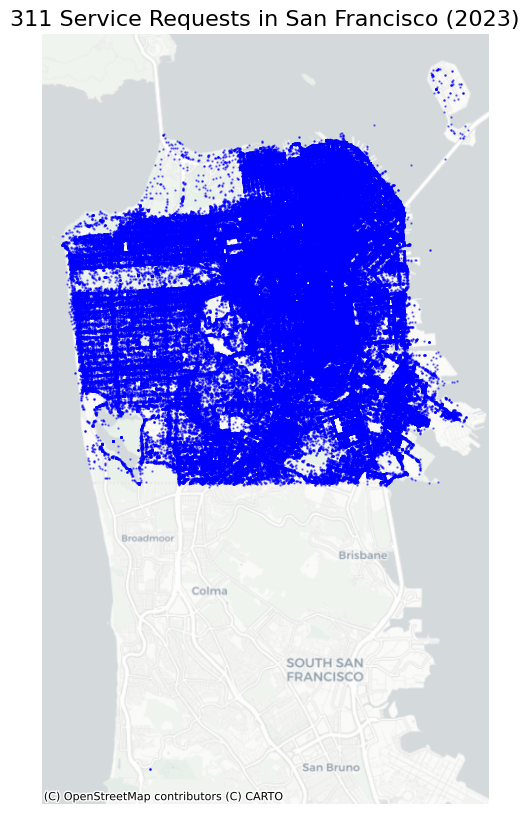

In [78]:
# Plot a simple visualization of the points
fig, ax = plt.subplots(figsize=(10, 10))
serv_req_gdf.plot(ax=ax, markersize=0.5, color='blue', alpha=0.5)
ax.set_title("311 Service Requests in San Francisco (2023)", fontsize=16)
# Overlay a basemap for context (optional)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=serv_req_gdf.crs)    
ax.axis('off')
plt.show()


### Quick Dashboard Describing Data

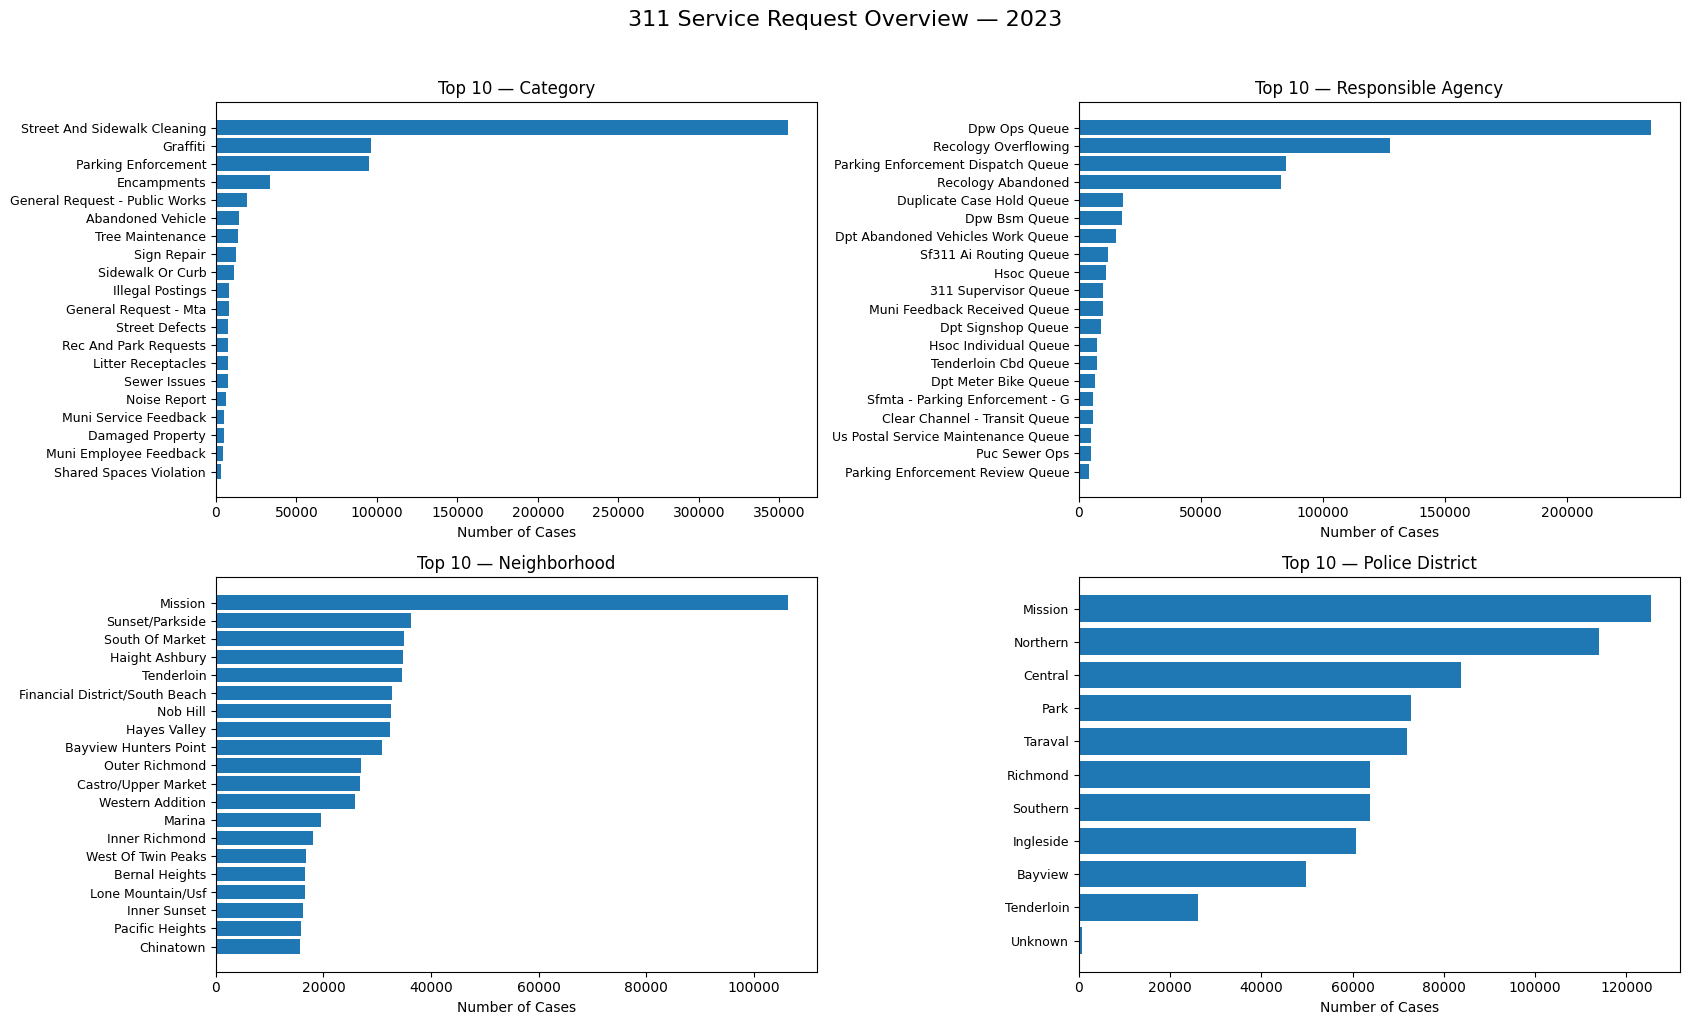

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))
axes = axes.flatten()

cat_info = [
    ('category', 'Top 10 — Category'),
    ('responsible_agency', 'Top 10 — Responsible Agency'),
    ('neighborhood', 'Top 10 — Neighborhood'),
    ('police_district', 'Top 10 — Police District'),
]

for ax, (col, title) in zip(axes, cat_info):
    if col in serv_req_gdf.columns:
        vc = (
            serv_req_gdf[col]
            .fillna('Unknown')
            .value_counts()
            .nlargest(20)
            .sort_values()
        )
        ax.barh(vc.index, vc.values)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Number of Cases")
        ax.tick_params(axis='y', labelsize=9)
    else:
        ax.text(0.5, 0.5, f"{col} not found", ha='center', va='center')
        ax.set_axis_off()

plt.suptitle("311 Service Request Overview — 2023", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

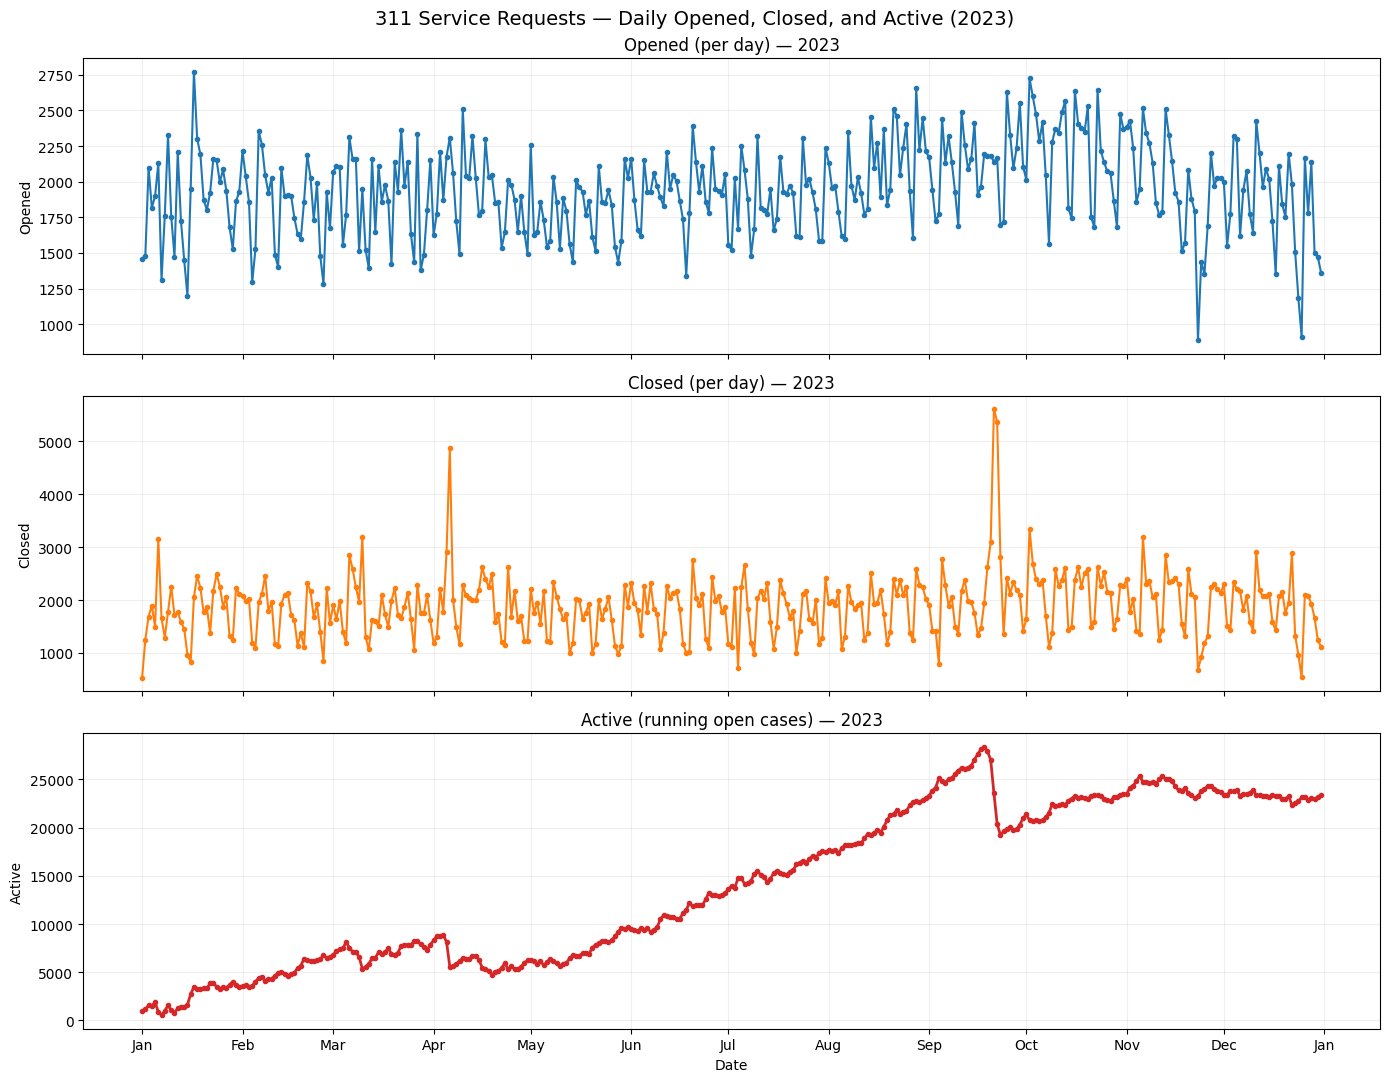

,all_cases,closed_cases,active_end_of_month
month,,,
2015-06-01,1,1,0
2015-07-01,1,1,0
2016-04-01,2,2,0
2016-05-01,3,3,0
2016-06-01,2,2,0
...,...,...,...
2023-11-01,58715,56329,21077
2023-12-01,56673,54597,23153
2024-06-01,3,3,23153


In [80]:
import matplotlib.dates as mdates

# Ensure datetime and filter to 2023
df = serv_req_gdf.copy()
df['opened'] = pd.to_datetime(df['opened'], errors='coerce')
df['closed'] = pd.to_datetime(df['closed'], errors='coerce')

# Keep records with at least one of opened/closed in 2023
df_2023 = df[
    (df['opened'].dt.year == 2023) | (df['closed'].dt.year == 2023)
].copy()

if df_2023.empty:
    print('No records with opened/closed year == 2023 found.')
else:
    # daily opened/closed counts (timestamped at midnight)
    df_2023['open_day'] = df_2023['opened'].dt.floor('D')
    df_2023['close_day'] = df_2023['closed'].dt.floor('D')

    opened_daily = df_2023.groupby('open_day').size().sort_index()
    closed_daily = df_2023.groupby('close_day').size().sort_index()

    # continuous date index for all days of 2023
    all_days = pd.date_range('2023-01-01', '2023-12-31', freq='D')
    opened_daily = opened_daily.reindex(all_days, fill_value=0)
    closed_daily = closed_daily.reindex(all_days, fill_value=0)

    # cumulative sums
    opened_cum = opened_daily.cumsum()
    closed_cum = closed_daily.cumsum()

    # active backlog = cumulative opened - cumulative closed
    active_daily = opened_cum - closed_cum

    # --- Subplots: separate stacked plots for opened, closed, and active ---
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 11), sharex=True)
    ax_open, ax_closed, ax_active = axes

    # Opened (per day)
    ax_open.plot(all_days, opened_daily, color='tab:blue', linewidth=1.5, marker='o', markersize=3)
    ax_open.set_title('Opened (per day) — 2023')
    ax_open.set_ylabel('Opened')
    ax_open.grid(alpha=0.2)

    # Closed (per day)
    ax_closed.plot(all_days, closed_daily, color='tab:orange', linewidth=1.5, marker='o', markersize=3)
    ax_closed.set_title('Closed (per day) — 2023')
    ax_closed.set_ylabel('Closed')
    ax_closed.grid(alpha=0.2)

    # Active (running open cases)
    ax_active.plot(all_days, active_daily, color='tab:red', linewidth=2, marker='o', markersize=3)
    ax_active.set_title('Active (running open cases) — 2023')
    ax_active.set_ylabel('Active')
    ax_active.set_xlabel('Date')
    ax_active.grid(alpha=0.2)

    # X axis formatting (months)
    ax_active.xaxis.set_major_locator(mdates.MonthLocator())
    ax_active.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.suptitle('311 Service Requests — Daily Opened, Closed, and Active (2023)', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

    # --- Monthly summary table (all, closed, active at month-end) ---
    df_2023['month'] = df_2023['opened'].dt.to_period('M').dt.to_timestamp()
    ts_opened_monthly = df_2023.groupby('month').size().sort_index()
    ts_closed_monthly = df_2023[df_2023['is_closed'].fillna(False)].groupby('month').size().reindex(ts_opened_monthly.index, fill_value=0)

    # active at month end = cumulative opened - cumulative closed at each month
    opened_cum_monthly = ts_opened_monthly.cumsum()
    closed_cum_monthly = ts_closed_monthly.cumsum()
    active_monthly = opened_cum_monthly - closed_cum_monthly

    try:
        summary = pd.DataFrame({
            'all_cases': ts_opened_monthly,
            'closed_cases': ts_closed_monthly,
            'active_end_of_month': active_monthly,
        }).fillna(0).astype(int)
        display(summary)
    except Exception:
        pass


### Caching DataFrame

This helps having to re-run the notebook the cleaning on each notebook boot.

In [81]:
serv_req_gdf.to_parquet('data/processed/serv_req_cleaned.parquet', index=False)

## Census ACS Data

In [82]:
# Pull ACS tract data for San Francisco County (FIPS 075), 2023 5-year ACS
census_data = Census(CENSUS_API_KEY)

sfCountyTracts_raw = census_data.acs5.state_county_tract(
    fields=(
        'NAME',
        'B01003_001E',  # total population
        'B19013_001E',  # median household income
        'B17001_001E',  # poverty universe
        'B17001_002E',  # below poverty
        'B19083_001E',  # Gini index
        'B25077_001E',  # median home value
        'B25064_001E',  # median rent
        'B25003_002E',  # owner-occupied units
        'B25003_003E',  # renter-occupied units
        'B15003_022E',  # bachelor's degree
        'B15003_023E',  # master's degree
        'B15003_025E',  # doctorate degree
        'B15003_001E',  # total population 25+ (education base)
        'B08301_010E',  # commute: drove alone
        'B08301_018E',  # commute: public transit
        'B08301_021E',  # commute: work from home
        'B03002_003E',  # white alone, not Hispanic
        'B03002_004E',  # Black or African American alone
        'B03002_006E',  # Asian alone
        'B03002_012E',  # Hispanic / Latino (any race)

    ),
    state_fips='06',
    county_fips='075',
    tract='*',
    year=2023
)

# convert to DataFrame
sfCountyTracts = pd.DataFrame(sfCountyTracts_raw)

### Calculating Useful Statistics

In [83]:
# Poverty rate
sfCountyTracts['poverty_rate'] = (
    sfCountyTracts['B17001_002E'] /
    sfCountyTracts['B17001_001E']
)

# % with bachelor's or higher (bachelor's + master's + doctorate)
sfCountyTracts['bachelors_plus_rate'] = (
    sfCountyTracts['B15003_022E'] +
    sfCountyTracts['B15003_023E'] +
    sfCountyTracts['B15003_025E']
) / sfCountyTracts['B15003_001E']

# % renter-occupied
sfCountyTracts['pct_renter_occupied'] = (
    sfCountyTracts['B25003_003E'] /
    (sfCountyTracts['B25003_002E'] + sfCountyTracts['B25003_003E'])
)

# Race shares
race_total = (
    sfCountyTracts['B03002_003E'] +  # white
    sfCountyTracts['B03002_004E'] +  # Black
    sfCountyTracts['B03002_006E'] +  # Asian
    sfCountyTracts['B03002_012E']    # Hispanic/Latino
)
sfCountyTracts['share_white']   = sfCountyTracts['B03002_003E'] / race_total
sfCountyTracts['share_black']   = sfCountyTracts['B03002_004E'] / race_total
sfCountyTracts['share_asian']   = sfCountyTracts['B03002_006E'] / race_total
sfCountyTracts['share_hispanic']= sfCountyTracts['B03002_012E'] / race_total

# Build a tract GEOID we can merge on later
sfCountyTracts['GEOID'] = (
    sfCountyTracts['state'] +
    sfCountyTracts['county'] +
    sfCountyTracts['tract']
)

In [84]:
# Rename columns to something readable for plotting/joins
acs_var_map = {
    'NAME': 'tract_name',
    'B01003_001E': 'total_population',
    'B19013_001E': 'median_household_income',
    'B17001_001E': 'poverty_universe',
    'B17001_002E': 'below_poverty_count',
    'B19083_001E': 'gini_index',
    'B25077_001E': 'median_home_value',
    'B25064_001E': 'median_rent',
    'B25003_002E': 'owner_occupied_units',
    'B25003_003E': 'renter_occupied_units',
    'B15003_022E': 'bachelors_count',
    'B15003_023E': 'masters_count',
    'B15003_025E': 'doctorate_count',
    'B15003_001E': 'education_base_25plus',
    'B08301_010E': 'workers_drive_alone',
    'B08301_018E': 'workers_public_transit',
    'B08301_021E': 'workers_work_from_home',
    'B03002_003E': 'white_alone',
    'B03002_004E': 'black_alone',
    'B03002_006E': 'asian_alone',
    'B03002_012E': 'hispanic_any_race',
}

sfCountyTracts.rename(columns=acs_var_map, inplace=True)

### Merging with Geodata Tract Information

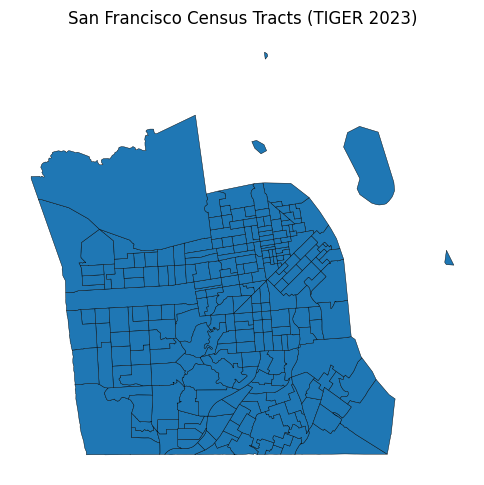

CRS: EPSG:4326
Number of tracts w/ population: 241
         GEOID  total_population  median_household_income
0  06075020602            2369.0                 204044.0
1  06075012202            3017.0                  54650.0
2  06075017102            3550.0                 176304.0
3  06075012302            2586.0                  55741.0
4  06075016801            4013.0                 148173.0


In [ ]:
ca_tracts = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_06_tract.zip"
)

# Filter to San Francisco County (County FIPS = '075')
sf_tracts = ca_tracts.loc[ca_tracts["COUNTYFP"] == "075"].copy()

# Reproject to match the CRS of your 311 GeoDataFrame
sf_tracts = sf_tracts.to_crs(serv_req_gdf.crs)

# Spatially crop to peninsula-ish bounding box
sf_tracts = sf_tracts.cx[-122.515:-122.365, 37.705:37.83].copy()

# Merge tracts with ACS attributes using GEOID (shapefile) ↔ geoid (ACS)
sf_tracts_acs = sf_tracts.merge(
    sfCountyTracts,
    left_on='GEOID',
    right_on='GEOID',
    how='left'
)

# Drop non-residential water/buffer leftovers by removing zero-pop tracts
sf_tracts_acs = sf_tracts_acs[sf_tracts_acs['total_population'] > 0].copy().to_crs(serv_req_gdf.crs)

# Plot with a basemap for sanity
fig, ax = plt.subplots(figsize=(6,6))
sf_tracts_acs.plot(ax=ax, edgecolor="black", linewidth=0.3)
ax.set_title("San Francisco Census Tracts (TIGER 2023)")
ax.set_axis_off()

# Add basemap
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=serv_req_gdf.crs)
plt.show()

## Cleaning ACS Data

In [106]:
def clean_negative_values(value):
    """Replace invalid or near-zero numeric ACS values with NaN."""
    if pd.isna(value) or value is None:
        return np.nan
    # Treat extreme negative or near-zero values as missing
    if value < 1e-3:
        return np.nan
    return value

# Apply to all numeric columns that can contain ACS estimates
numeric_cols = [
    "median_household_income", "total_population", "poverty_universe",
    "below_poverty_count", "gini_index", "median_home_value",
    "median_rent", "owner_occupied_units", "renter_occupied_units",
    "bachelors_count", "masters_count", "doctorate_count",
    "education_base_25plus", "workers_drive_alone", "workers_public_transit",
    "workers_work_from_home", "white_alone", "black_alone", "asian_alone",
    "hispanic_any_race", "poverty_rate", "bachelors_plus_rate",
    "pct_renter_occupied", "share_white", "share_black",
    "share_asian", "share_hispanic"
]

for col in numeric_cols:
    if col in sf_tracts_acs.columns:
        sf_tracts_acs[col] = sf_tracts_acs[col].apply(clean_negative_values)

sf_tracts_acs.to_file('data/processed/sf_tracts_cleaned.gpkg', driver='GPKG')

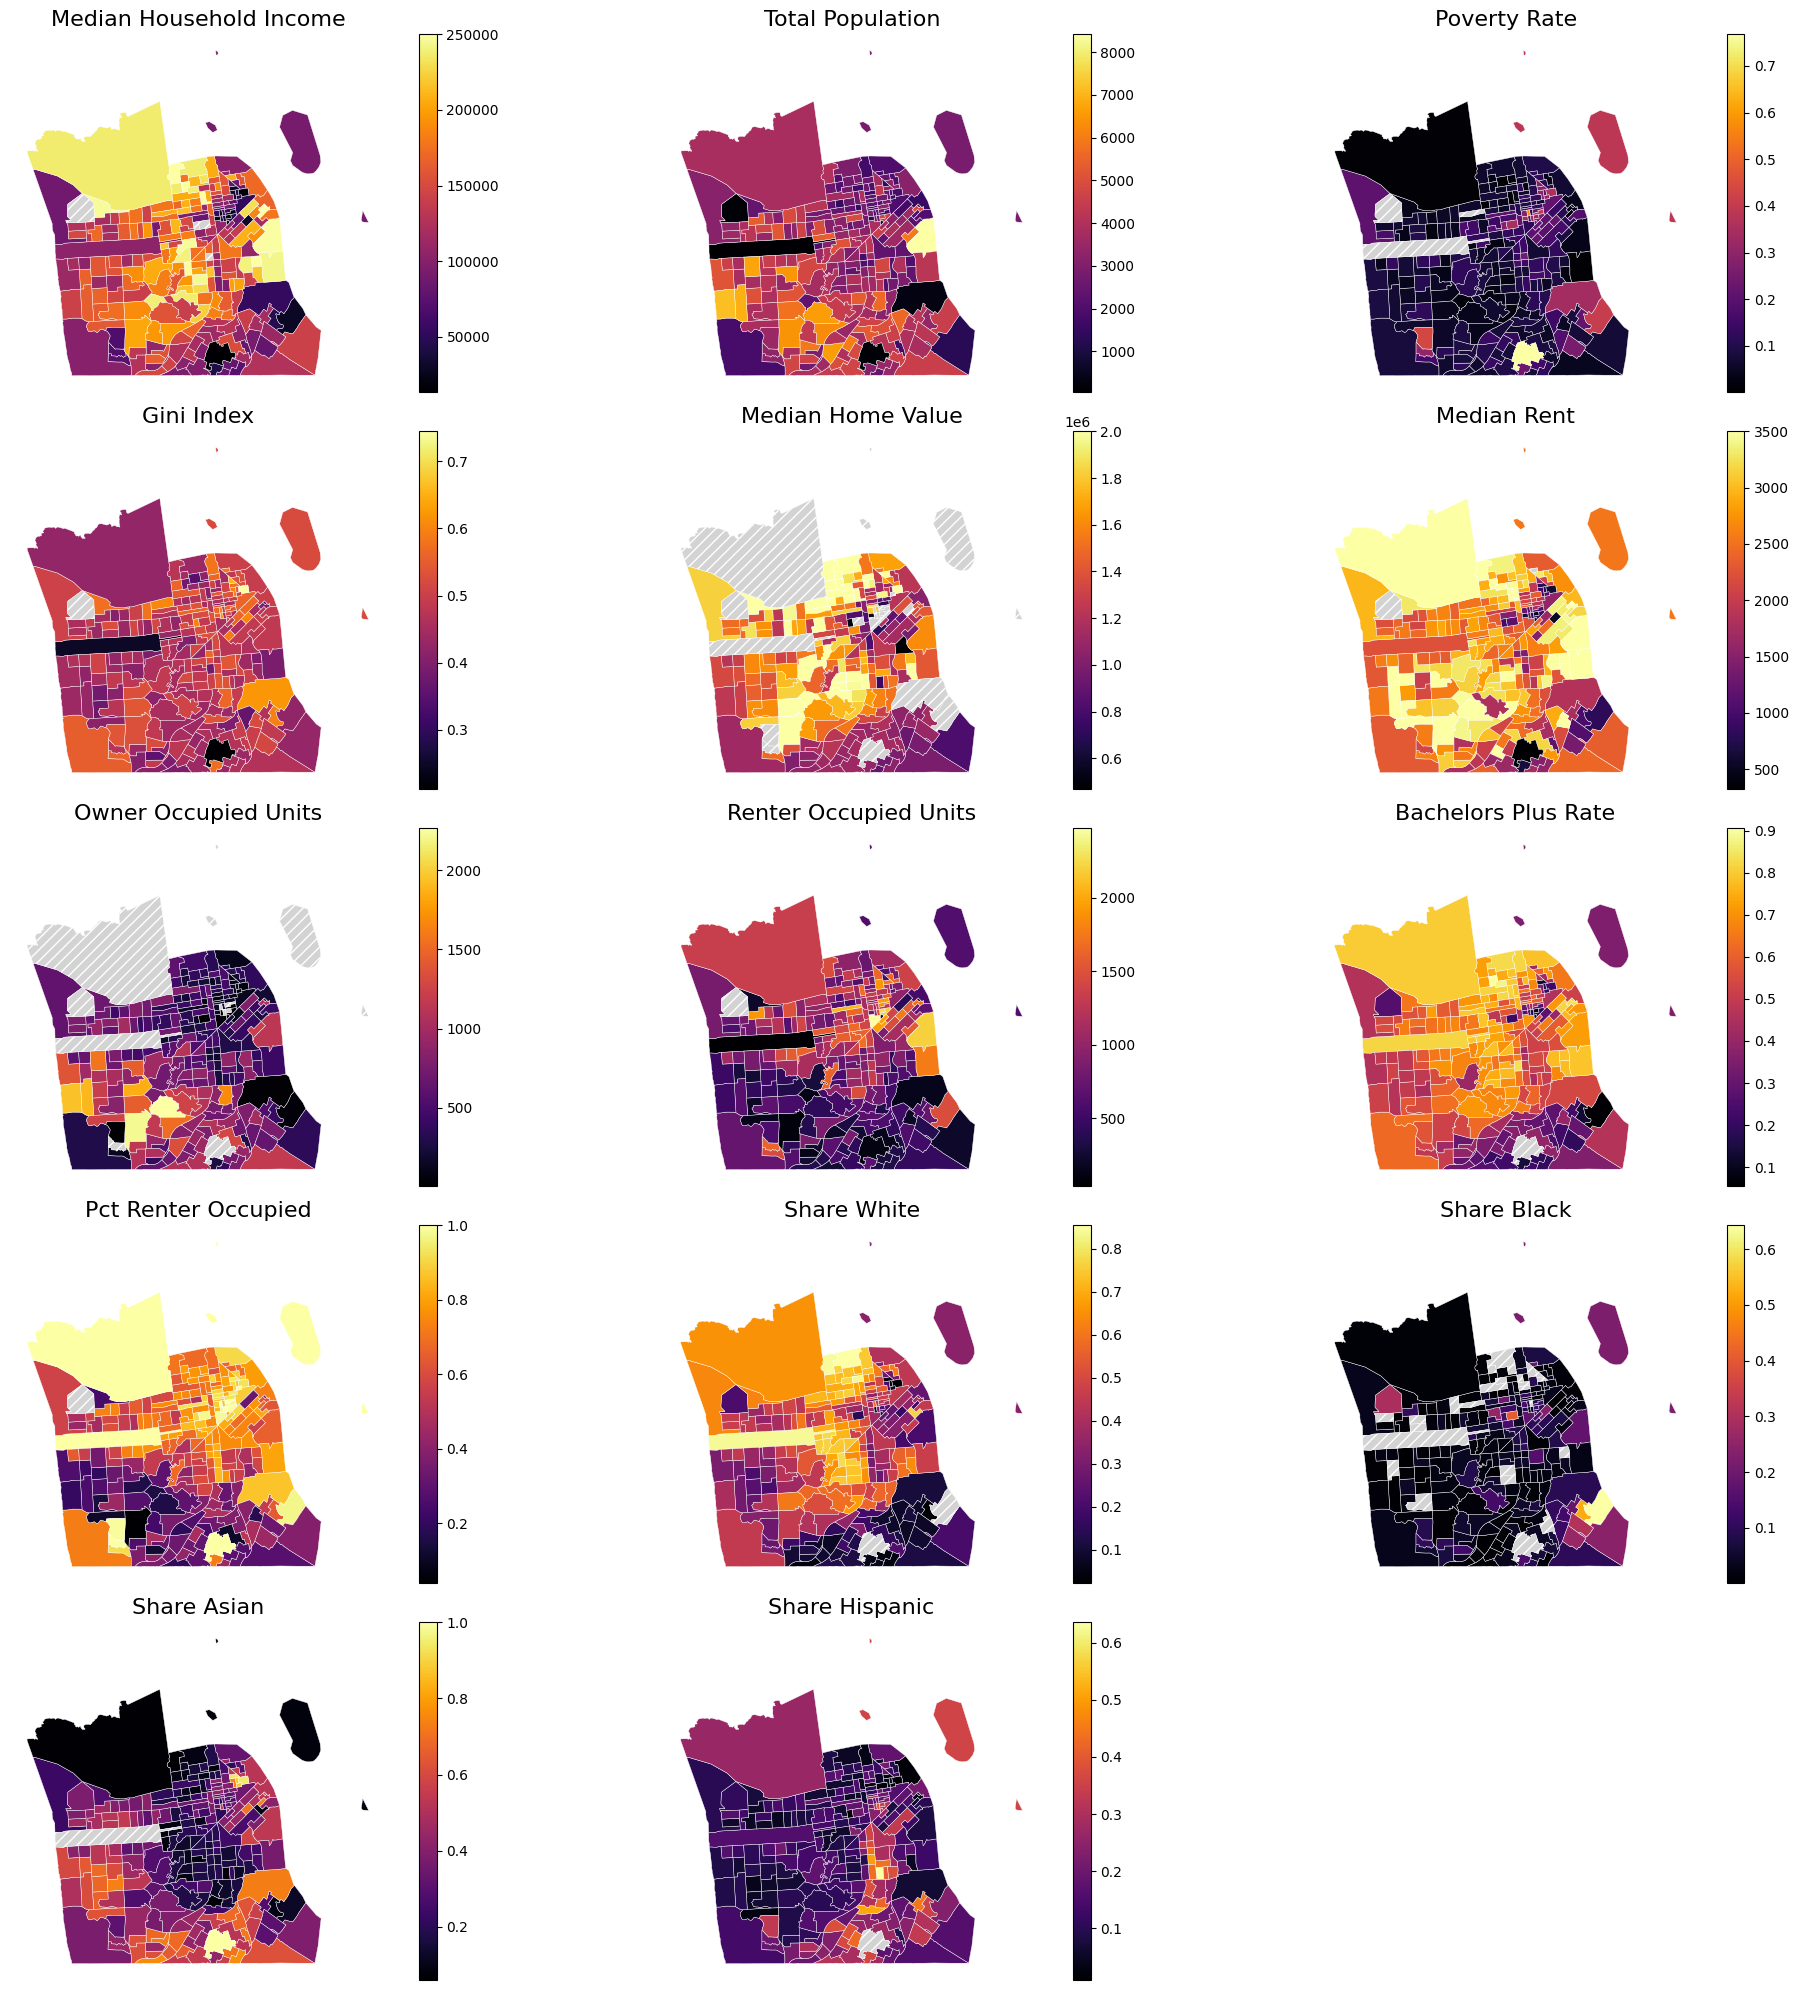

In [ ]:
# Columns from acs + the ones we derived
acs_columns = [
    "median_household_income", "total_population", "poverty_rate", "gini_index",
    "median_home_value", "median_rent", "owner_occupied_units", "renter_occupied_units",
    "bachelors_plus_rate", "pct_renter_occupied", "share_white", "share_black",
    "share_asian", "share_hispanic"
]

# Printing multiple maps in a grid
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(acs_columns):
    ax = axes[i]
    
    sf_tracts_acs.plot(
        ax=ax,
        column=col,
        legend=True,
        edgecolor="white",
        linewidth=0.3,
        cmap="inferno",
        missing_kwds={"color": "lightgray", "hatch": "///", "label": "No data"}
    )
    ax.set_title(col.replace("_", " ").title(), fontsize=16)
    ax.set_axis_off()

# Hide extra subplots if fewer than 16
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()